In [1]:
def get_dmg_table(ct, pvalue_cutoff, use_gender):
    use_male = male[male['celltype']== ct]
    use_female = female[female['celltype'] == ct]
    
    if use_gender == 'Female':
        dmg_female = use_female[(use_female[use_col] < pvalue_cutoff) & (use_female['abs_change'] > change_cutoff)]
        dmg_male = use_male.loc[dmg_female.index]
    elif use_gender == 'Male':
        dmg_male = use_male[(use_male[use_col] < pvalue_cutoff) & (use_female['abs_change'] > change_cutoff)]
        dmg_female = use_female.loc[dmg_male.index]
        
    return dmg_male, dmg_female

In [2]:
import glob
import anndata
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
from ALLCools.mcds import MCDS
from ALLCools.plot import *
from wmb import cemba
from scipy.stats import zscore
import numpy as np
import pathlib
import xarray as xr
from scipy import stats

In [3]:
gene_name_to_id = joblib.load('240112_DMG_CEF/gene_name_to_id_dict')
gene_id_to_name = joblib.load('240112_DMG_CEF/gene_id_to_name_dict')

gene_meta_path = '/home/qzeng/project/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
gene_meta = pd.read_csv(gene_meta_path, index_col ='gene_id', sep='\t')

In [4]:
# load
male = pd.read_csv('result/Male.CGN.AllGene.Anova.Result.csv', index_col =0)
female = pd.read_csv('result/Female.CGN.AllGene.Anova.Result.csv', index_col =0)

# exclude chrX
male['chrom'] = gene_meta['chrom']
male = male[male['chrom'] != 'chrX']

#get shared genes
shared_genes = male.index.intersection(female.index)
female = female.loc[shared_genes]
male = male.loc[shared_genes]

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
mc_type = 'CGN'

In [7]:
f_female = female[(female['abs_change']> 0) & (female['corrected_pvalue'] < 0.01)]

In [9]:
cell_counts = f_female['celltype'].value_counts().index
cell_counts

Index(['Oligo NN', 'DG-PIR Ex IMN', 'OPC NN', 'DG Glut', 'Microglia NN',
       'Astro-TE NN', 'Astro-NT NN', 'STR D1 Gaba', 'L6b/CT ENT Glut',
       'STR D2 Gaba', 'L2/3 IT CTX Glut', 'L2/3 IT ENT Glut',
       'L2/3 IT PPP Glut', 'L6 CT CTX Glut', 'CEA-BST Gaba', 'CA1-ProS Glut',
       'MEA-COA Glut', 'L4/5 IT CTX Glut', 'L6 IT CTX Glut', 'VLMC NN',
       'MEA-BST Gaba', 'L5 ET CTX Glut', 'PB Evx2 Glut', 'STR-PAL Chst9 Gaba',
       'L5 NP CTX Glut', 'PAG Glut', 'L5 IT CTX Glut', 'Pvalb Gaba',
       'LA-BLA-BMA-PA Glut', 'CA3 Glut', 'Sst Gaba', 'STR D1 Sema5a Gaba',
       'CS-PRNr-DR En1 Sox2 Gaba', 'Vip Gaba'],
      dtype='object')

In [ ]:
'Oligo NN', 'DG-PIR Ex IMN', 'OPC NN', 'DG Glut', 'Microglia NN',
       'Astro-TE NN', 'Astro-NT NN', 'STR D1 Gaba', 'L6b/CT ENT Glut',
       'STR D2 Gaba', 'L2/3 IT CTX Glut', 'L2/3 IT ENT Glut',
       'L2/3 IT PPP Glut', 'L6 CT CTX Glut', 'CEA-BST Gaba', 'CA1-ProS Glut',

In [24]:
# plot_cts = ['OPC NN',
#  'Microglia NN',
#  'Oligo NN',
#  'Astro-NT NN',
#  'Astro-TE NN'] # 

plot_cts = ['STR D1 Gaba', 'L6b/CT ENT Glut',
       'STR D2 Gaba', 'L2/3 IT CTX Glut', 'L2/3 IT ENT Glut',
       'L2/3 IT PPP Glut', 'L6 CT CTX Glut']
use_gender = 'Female'
use_col = 'corrected_pvalue'
change_cutoff = 0.02

In [25]:
len(plot_cts)

7

In [26]:
pvalue_dict = {'OPC NN':1e-10,
 'Oligo NN':1e-20,
 'Microglia NN':1e-10,
 'Astro-NT NN':1e-10,
 'Astro-TE NN':1e-10  }

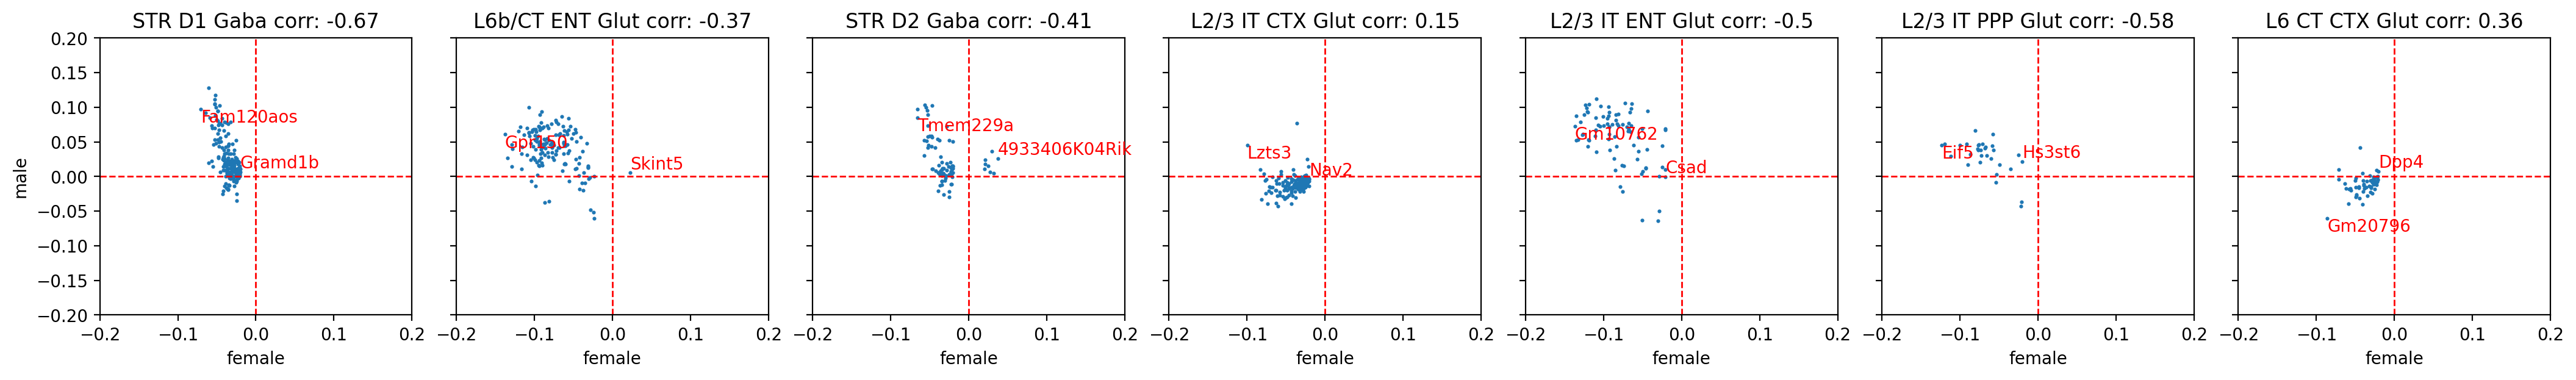

In [28]:
ncols = 7
nrows = 1
fig, axes = plt.subplots(figsize = (3*ncols, 3*nrows), dpi = 200, constrained_layout = True, 
                      ncols = ncols, nrows = nrows, sharey = True)
female_dmg = []
pvalue_cutoff = 1e-3
for ct , ax in zip(plot_cts, axes.ravel()):
    #pvalue_cutoff = pvalue_dict[ct]
    dmg_male, dmg_female = get_dmg_table(ct, pvalue_cutoff, use_gender)
    
    # dmg_male = dmg_male[dmg_male['corrected_pvalue'] < 0.01]
    # dmg_female = dmg_female.loc[dmg_male.index]
    female_dmg.append(dmg_female)
    result = pd.concat([dmg_male['methylation_change'], dmg_female['methylation_change']], axis =1)
    result.columns = ['male', 'female']
    
    corr, pvalue = stats.pearsonr(result['male'], result['female'])
    corr = corr.round(2)
    
    sns.scatterplot(data = result,
                ax = ax, 
                s = 5, 
                linewidth =0,
                x ='female',y = 'male')
    ax.axvline(x = 0, ls = '--', lw = 1, c = 'r')
    ax.axhline(y = 0, ls = '--', lw = 1, c = 'r')
    ax.set_title(f"{ct} corr: {corr}")  
    ax.set(xlim = (-0.2, 0.2), ylim = (-0.2, 0.2))
    #print(f"{ct}:{pvalue_cutoff}")
    
    for value_type in ['max', 'min']:
        if value_type == 'max':
            index = dmg_female['methylation_change'].idxmax()
        else:
            index = dmg_female['methylation_change'].idxmin()
        
        female_value = result.loc[index, 'female']
        male_value = result.loc[index, 'male']
        
        ax.text(female_value, male_value, str(gene_id_to_name[index]), fontsize=10, color='red',
                verticalalignment='bottom' if value_type == 'max' else 'top')


        

In [17]:
female_dmg = pd.concat(female_dmg, axis = 0)

In [21]:
female_dmg['gene_name']   =female_dmg.index.map(gene_id_to_name)

In [23]:
female_dmg.to_csv('result/NN.CGN.aDNG.csv')